# Filtro de Bayer
El filtro de Bayer es un tipo de matriz de filtros de color (CFA, Color Filter Array) utilizado en cámaras digitales para capturar imágenes en color. Fue inventado por Bryce Bayer en 1974 y se emplea para permitir que los fotosensores de las cámaras, que solo pueden medir la intensidad de la luz, capten información sobre el color. El filtro de Bayer es fundamental para las cámaras digitales modernas, ya que permite que los sensores capturen imágenes en color de manera eficiente.

Las cámaras digitales tienen una matriz de fotosensores que capturan la luz, pero no pueden distinguir la longitud de onda, es decir, el color de la luz. Entonces, el filtro de Bayer se coloca sobre los fotosensores para que cada uno solo reciba un determinado color (rojo, verde o azul). El patrón RGGB define la disposición de los filtros: en un arreglo de 2x2 píxeles, hay 2 píxeles verdes, 1 rojo y 1 azul (se utiliza el doble de píxeles verdes porque el ojo humano es más sensible a la luz verde, lo que mejora la percepción visual). 

La imagen capturada inicialmente es incompleta, ya que cada píxel solo registra un color. Para obtener una imagen completa, es necesario reconstruir las componentes rojo, verde y azul en cada píxel, un proceso conocido como demosaicing

# Demosaicing
Demosaicing es el proceso que permite reconstruir una imagen completa a partir del patrón de Bayer, utilizando técnicas de interpolación para estimar los colores que no fueron medidos en cada píxel. Este proceso utiliza la información de los píxeles vecinos para estimar los valores faltantes de color.

El objetivo es recuperar la imagen completa a partir del patrón de Bayer, donde cada píxel solo tiene información de un color (rojo, verde o azul). Hace uso de un metodo que se basa en técnicas de interpolación para estimar los valores de color no medidos. Cómo se combine esta información en el resultado dependerá de los algoritmos. La elección del algoritmo está sujeta a la capacidad de procesamiento, el costo computacional y energético, y la calidad de la imagen deseada.

## Tipos de Algoritmos de Demosaicing
### Interpolación por vecino más cercano (Nearest-neighbor interpolation): 
Reemplaza las componentes de color faltantes de un píxel con el valor del píxel más cercano que tenga esa información.
### Interpolación bilineal (Bilinear interpolation): 
Sustituye la componente de color faltante por la media aritmética de los valores de los píxeles vecinos que tienen información de ese color.
### Algoritmos adaptativos: 
Utilizan la correlación espacial o espectral de los píxeles para estimar de manera más precisa las componentes de color faltantes.

El demosaicing es fundamental para obtener una imagen en color de alta calidad a partir de los datos capturados por el filtro de Bayer.

In [1]:
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
import math

In [2]:
def wbscalematrix(m, n, wb_scales, align):
    # Makes a white-balance scaling matrix for an image of size m-by-n
    # from the individual RGB white balance scalar multipliers [wb_scales] = [R_scale G_scale B_scale].
    #
    # [align] is string indicating the 2x2 Bayer arrangement: 
    # 'rggb':  
    #    R G 
    #    G B 
    # 'gbrg':
    #    G B
    #    R G
    # 'grbg','bggr' follow as before.

    # First, for convenience only, we're going to fill the scale matrix
    # with all green pixels. Then, we're going to replace the red and blue 
    # pixels later on with the correct scalars.
    #
    scalematrix = wb_scales[1] * np.ones((m,n)) # Initialize to all green values

    # Fill in the scales for the red and blue pixels across the matrix
    if (align == 'rggb'):
        scalematrix[0::2, 0::2] = wb_scales[0] # r
        scalematrix[1::2, 1::2] = wb_scales[2] # b
    elif (align == 'bggr'):
        scalematrix[1::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 0::2] = wb_scales[2] # b
    elif (align == 'grbg'):
        scalematrix[0::2, 1::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    elif (align == 'gbrg'):
        scalematrix[1::2, 0::2] = wb_scales[0] # r
        scalematrix[0::2, 1::2] = wb_scales[2] # b
    return scalematrix

In [3]:
def apply_cmatrix(img, cmatrix):
    # Applies color transformation CMATRIX to RGB input IM. 
    # Finds the appropriate weighting of the old color planes to form the new color planes, 
    # equivalent to but much more efficient than applying a matrix transformation to each pixel.
    if (img.shape[2] != 3):
        raise ValueError('Apply cmatrix to RGB image only.')

    r = cmatrix[0,0] * img[:,:,0] + cmatrix[0,1] * img[:,:,1] + cmatrix[0,2] * img[:,:,2]
    g = cmatrix[1,0] * img[:,:,0] + cmatrix[1,1] * img[:,:,1] + cmatrix[1,2] * img[:,:,2]
    b = cmatrix[2,0] * img[:,:,0] + cmatrix[2,1] * img[:,:,1] + cmatrix[2,2] * img[:,:,2]
    corrected = np.stack((r,g,b), axis=2)
    return corrected

In [5]:
def debayering(input):
    # Bilinear Interpolation of the missing pixels
    #
    # Assumes a Bayer CFA in the 'rggb' layout
    #   R G R G
    #   G B G B
    #   R G R G
    #   G B G B
    #
    # Input: Single-channel rggb Bayered image
    # Returns: A debayered 3-channels RGB image
    #
    img = input.astype(np.double)

    m = img.shape[0]
    n = img.shape[1]

    # First, we're going to create indicator masks that tell us
    # where each of the color pixels are in the bayered input image
    # 1 indicates presence of that color, 0 otherwise
    red_mask = np.tile([[1,0],[0,0]], (int(m/2), int(n/2)))
    green_mask = np.tile([[0,1],[1,0]], (int(m/2), int(n/2)))
    blue_mask = np.tile([[0,0],[0,1]], (int(m/2), int(n/2)))

    r = np.multiply(img, red_mask)
    g = np.multiply(img, green_mask)
    b = np.multiply(img, blue_mask)

    # Confirm for yourself: 
    # - What are the patterns of values in the r,g,b images?
    # Sketch them out to help yourself.

    # Next, we're going to fill in the missing values in r,g,b
    # For this, we're going to use filtering - convolution - to implement bilinear interpolation.
    # - We know that convolution allows us to perform a weighted sum
    # - We know _where_ our pixels lie within a grid, and where the missing pixels are
    # - We know filters come in odd sizes

    # Interpolating green:
    filter_g = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_g = convolve2d(g, filter_g, 'same')
    g = g + missing_g

    # To conceptualize how this works, let's continue to draw it out on paper.
    # - Sketch the first 5 rows and columns of the g image
    # - Sketch the 3x3 filter and add the numeric weights (they sum to 1)
    # - Sketch the output image

    # Move the filter through the valid region of the image.
    # - What is the output at pixel 1,1 ?  [0-index, remember]
    # - What is the output at pixel 2,1 ?
    # - What is the output at pixel 3,1 ?
    # - What is the output at pixel 1,2 ?
    # - What is the output at pixel 2,2 ?
    # - What is the output at pixel 3,2 ?

    # See how it works? 
    # The filter only produces output if the surrounding pixels match its pattern.
    # When they do, it produces their mean value.

    # Note that we're going to have some incorrect values at the image boundaries, 
    # but let's ignore that for this exercise.

    # Now, let's try it for blue. This one is a two-step process.
    # - Step 1: We fill in the 'central' blue pixel in the location of the red pixel
    # - Step 2: We fill in the blue pixels at the locations of the green pixels, 
    #           similar to how the green interpolation worked, but offset by a row/column
    #
    # Sketch out the matrices to help you follow.
    # Remember, we'll still have some incorrect value at the image boundaries.

    # Interpolating blue:
    # Step 1:
    filter1 = 0.25 * np.array([[1,0,1],[0,0,0],[1,0,1]])
    missing_b1 = convolve2d(b, filter1, 'same')
    # Step 2:
    filter2 = 0.25 * np.array([[0,1,0],[1,0,1],[0,1,0]])
    missing_b2 = convolve2d(b + missing_b1, filter2, 'same')
    b = b + missing_b1 + missing_b2

    # OK! Only red left.

    # Interpolation for the red at the missing points
    # TODO: Complete the following two lines. Follow a similar strategy to the blue channel.
    missing_r1 = convolve2d(r, filter1, 'same')
    missing_r2 = convolve2d(r + missing_r1, filter2, 'same')
    r = r + missing_r1 + missing_r2

    output = np.stack((r,g,b), axis=2)
    return output

In [9]:
# Primero, utilizamos el programa dcraw para ejecutar una rutina de reconocimiento en la imagen de prueba sample.DNG. 
# Como resultado, obtenemos los siguientes valores

# Step 0: Convert RAW file to TIFF
black = 0
saturation = 16383  
wb_multipliers = [2.217041, 1.000000, 1.192484]

# Open the CFA image
raw_data = Image.open('./assets/sample.tiff')
raw = np.array(raw_data).astype(np.double)

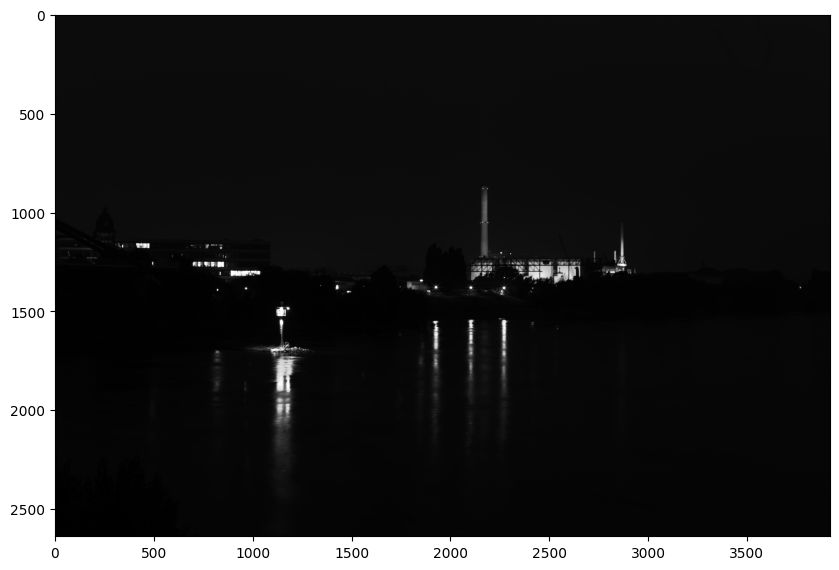

In [10]:
# En otro paso, se linealiza y normaliza el contenido de los píxeles para utilizar el rango dinámico completo.

# Step 1: Normalization
linear_bayer = (raw - black) / (saturation - black)

# Plot the CFA image
plt.figure(figsize=(10, 10))
plt.imshow(linear_bayer, cmap='gray')
plt.show()

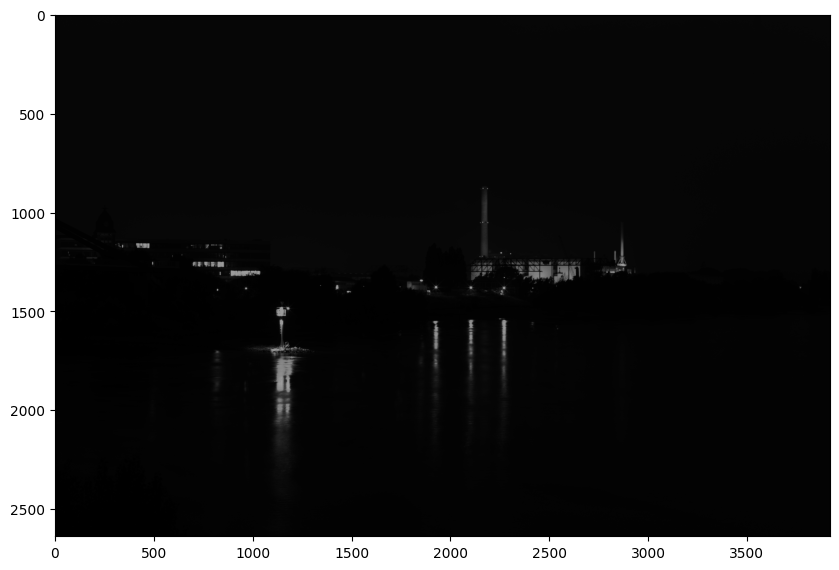

In [11]:
# Se escalan las componentes de color rojo, verde y azul con el objetivo de llevar los colores presentes en la imágen 
# a una escala apropiada tomando como referencia el color blanco. 
# Esto es lo que se conoce como balance de blancos.

# Step 2: White balancing
mask = wbscalematrix(linear_bayer.shape[0], linear_bayer.shape[1], wb_multipliers, 'rggb')
balanced_bayer = np.multiply(linear_bayer, mask)

# Plot balanced result
plt.figure(figsize=(10, 10))
plt.imshow(balanced_bayer, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


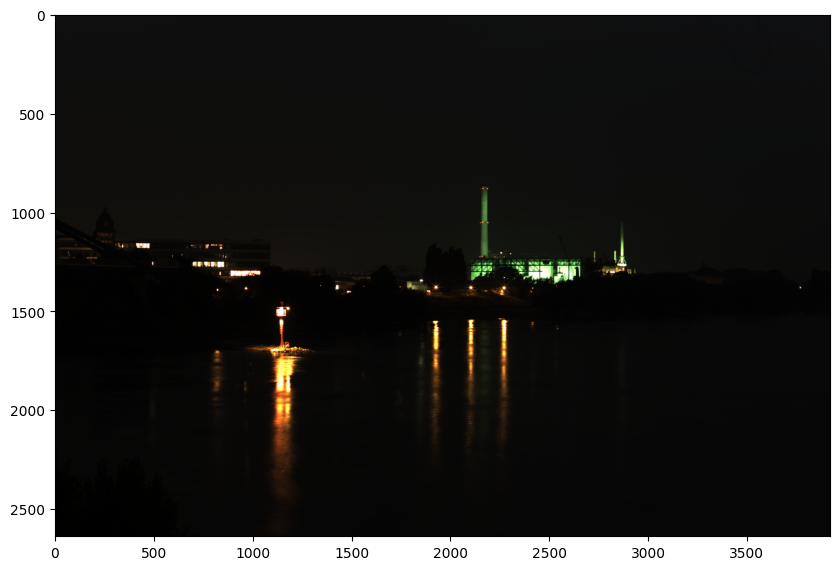

In [12]:
# Se aplica el debayering o demosaicing, esto es, una interpolación para reconstruir las componentes de color rojo, verde y azul 
# que no se encuentran presentes por el filtrado Bayer que aplican las cámaras fotográficas. 
# En este caso, se realizan promediados para reconstruir pixel a pixel estas componentes.

# Step 3: Debayering (also called demosaicing)
lin_rgb = debayering(balanced_bayer)

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(lin_rgb)
plt.show()

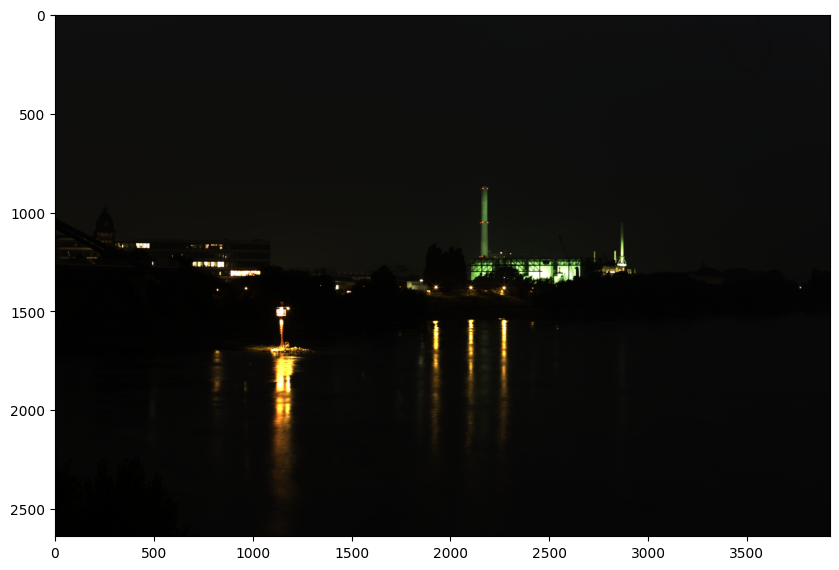

In [13]:
# Se aplica una transformación para llevar los colores a un espacio de color sRGB que puede ser interpretado 
# y representado correctamente por Windows y las computadores modernas

# Step 4: Color space conversion --- we do this one for you.
# Convert to sRGB. xyz2cam is found in dcraw's source file adobe_coeff.
rgb2xyz = np.array([[0.4124564, 0.3575761, 0.1804375],
            [0.2126729, 0.7151522, 0.0721750],
            [0.0193339, 0.1191920, 0.9503041]])
xyz2cam = np.array([[0.6653, -0.1486, -0.0611],
            [-0.4221, 1.3303, 0.0929],
            [-0.0881, 0.2416, 0.7226]])
rgb2cam = xyz2cam * rgb2xyz # Assuming previously defined matrices
denom = np.tile(np.reshape(np.sum(rgb2cam,axis=1),(3,-1)), (1,3))
rgb2cam = np.divide(rgb2cam, denom) # Normalize rows to 1
cam2rgb = np.linalg.inv(rgb2cam)
lin_srgb = apply_cmatrix(lin_rgb, cam2rgb)
lin_srgb[lin_srgb > 1.0] = 1.0 # Always keep image clipped b/w 0-1
lin_srgb[lin_srgb < 0.0] = 0.0

# Plot the results
plt.figure(figsize=(10, 10))
plt.imshow(lin_srgb)
plt.show()

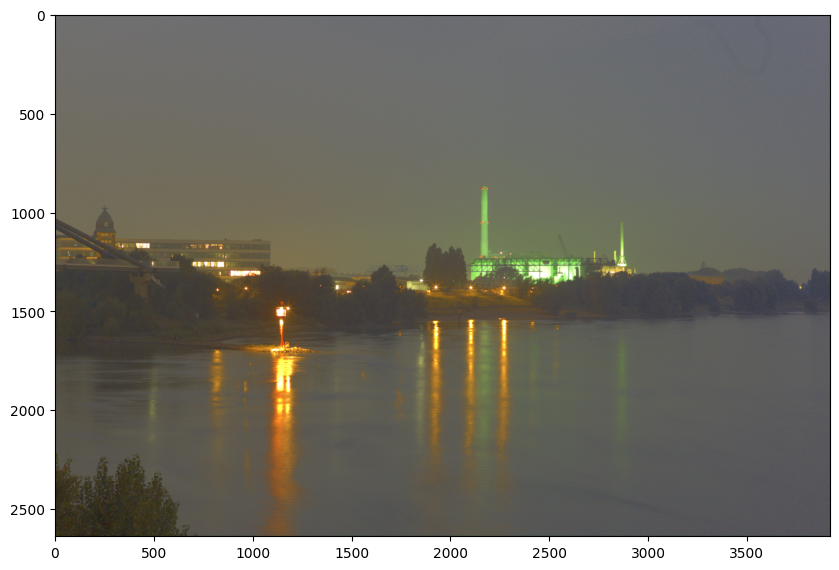

In [14]:
# Finalmente, se debe aplicar una corrección de brillo y de gamma.

# Step 5: Brightness and gamma correction
gamma_hsv = matplotlib.colors.rgb_to_hsv(lin_srgb)
adjust_brightness = 0.00
magic_touch = 0.05
gamma_hsv[:,:,2] += adjust_brightness
gamma = np.log10(0.5) / np.log10(gamma_hsv[:,:,2].mean()) + magic_touch
gamma_hsv[:,:,2] = np.power(gamma_hsv[:,:,2], gamma)
gamma_srgb = matplotlib.colors.hsv_to_rgb(gamma_hsv)
gamma_srgb[gamma_srgb > 1.0] = 1.0
gamma_srgb[gamma_srgb < 0.0] = 0.0


plt.figure(figsize=(10, 10))
plt.imshow(gamma_srgb)
plt.show()